## Neural Wrappers introduction tutorial

This tutorial is a "how to" or "best practice" around how most things are implemented or expected to be done using the neural wrappers library. The purpose of the library is to simplify training, testing and evaluation steps using the PyTorch library. It implements various helpful functions, such as `train_generator` (similar to a `fit_generator` Keras function), callbacks (`SaveModel`, `PlotMetrics` or custom ones by subclassing `Callback`).


##### 1. Model

To load the library, all you have to do is subclass `NeuralNetworkPyTorch` instead of PyTorch's `nn.Module`. Basically the class is a subclass of `nn.Module` that has additional methods/fields inserted.

`
import torch.nn as nn
class MyAwesomeNN(nn.Module):
    def __init__(self):
        super(MyAwesomeNN, self).__init__()
        ...
->
from neural_wrappers.pytorch import NeuralNetworkPyTorch
class MyAwesomeNN(NeuralNetworkPyTorch):
    def __init__(self):
        super().__init__()
`


In [1]:
from neural_wrappers.pytorch import NeuralNetworkPyTorch
class MyAwesomeNN(NeuralNetworkPyTorch):
    def __init__(self):
        super().__init__()
        
model = MyAwesomeNN()
print(model.summary())

[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 0. Trainable parameters: 0.
Hyperparameters: 
Metrics: 'Loss'
Callbacks: None
Optimizer: None
Optimizer Scheduler: None
GPU: False


##### 2. Data

The built-in class that handles datasets is `DatasetReader`, however it is not necessary to use it, since any regular data generator will suffice. When creating a new reader, one must subclass this class and implement the dataset specific data loading parts. We'll take as example a simple logistic regression task with 3 classes, generated from a Gaussian distribution with various means/stds.

The important methods are `generator = iterate_once(Type, miniBatchSize, ...)`, which returns a generator that can be directly fed to `train_generator(generator, numSteps, numEpochs, ...)`. The other important method is `numSteps = getNumIterations(Type, miniBatchSize)`, which returns the number of iterations per epoch.

Type is simply a string, that is usually only one of 3 possible values (95% of times 2 values): `train`, `validation`, `test`.

The naming convention is x (data), t (targets) and y (outputs). Thus a loss function would look like `y = Model(x); L = loss(y, t).`

In [2]:
from neural_wrappers.readers import DatasetReader
from neural_wrappers.utilities import toCategorical
import numpy as np

class Reader(DatasetReader):
    def __init__(self):
        self.numClasses = 3
        # This field is expected s.t. the default getNumIterations(...) method works. One can overwrite it however,
        #  if a more special formula for computing the number of iterations per epoch is required.
        self.numData = {"train" : 9999, "validation" : 3333, "test" : 999}
        means = [-1, 0, 1.33]
        stds = [0, 0.5, 0]
        self.numFeatures = 5
        
        self.data = {k : self.generateData(k, means, stds) for k in self.numData.keys()}
        print("Dataset:", " | ".join(["%s : (X: %s, t: %s)" % (k, self.data[k][0].shape, self.data[k][1].shape) \
                                      for k in self.data.keys()]) )
              
    def generateData(self, k, means, stds):
        N = self.numData[k]
        assert N % self.numClasses == 0
        x = np.zeros((N, self.numFeatures), dtype=np.float32)
        t = np.zeros((N, ), dtype=np.uint32)
        for i in range(self.numClasses):
            startIndex, endIndex = i * (N // 3), (i + 1) * (N // 3)
            x[startIndex : endIndex] = np.random.randn(N // self.numClasses, self.numFeatures) * stds[i] + means[i]
            t[startIndex : endIndex] = i
        
        # Shuffle the data so it's independent and identically distributed
        np.random.seed(42)
        perm = np.random.permutation(N)
        x = x[perm]
        # We also need to make the targets one hot encoded: [1] => [0, 1, 0] for 3 classes
        t = t[perm]
        t = toCategorical(t, numClasses=self.numClasses)
        return x, t
    
    # This method is our generator, which must, at each step, return a batch of (X, t) items.
    def iterate_once(self, type, miniBatchSize):
        assert type in ("train", "validation", "test")

        data = self.data[type]
        x, t = data[0], data[1]
        numIterations = self.getNumIterations(type, miniBatchSize)
        for i in range(numIterations):
            startIndex = i * miniBatchSize
            endIndex = min((i + 1) * miniBatchSize, self.numData[type])
            assert startIndex < endIndex, "startIndex < endIndex. Got values: %d %d" % (startIndex, endIndex)
            yield x[startIndex : endIndex], t[startIndex : endIndex]


Now that we've seen how a dataset generator should look like, let's play a little with the provided methods to see how they can help us.

In [3]:
reader = Reader()
## Vary the number of batch size
print("Varying batch size:")
for MB in [1, 2, 3, 5, 13, 17, 20]:
    trainNumSteps = reader.getNumIterations("train", miniBatchSize=MB)
    print(MB, "=>", trainNumSteps, end=" | ")
print("")

print("Calling the generator and getting one batch")
generator = reader.iterate_once("train", miniBatchSize=20)
x, t = next(generator)
print("First batch:", x.shape, t.argmax(axis=-1))

Dataset: train : (X: (9999, 5), t: (9999, 3)) | validation : (X: (3333, 5), t: (3333, 3)) | test : (X: (999, 5), t: (999, 3))
Varying batch size:
1 => 9999 | 2 => 5000 | 3 => 3333 | 5 => 2000 | 13 => 770 | 17 => 589 | 20 => 500 | 
Calling the generator and getting one batch
First batch: (20, 5) [1 2 0 2 1 2 0 2 1 0 0 1 1 1 1 1 0 1 2 1]


##### 3. Defining a model

First, we define a model that takes the data (X), which has 5 features, and projects them into the 3 dimensional output, corresponding to the 3 classes. Then, we call the softmax function to get probabilities.

In [4]:
import torch as tr
import torch.nn as nn

class Model(NeuralNetworkPyTorch):
    def __init__(self, numFeatures, outClasses):
        super().__init__()
        self.fc1 = nn.Linear(in_features=numFeatures, out_features=outClasses)
    
    def forward(self, x):
        y = self.fc1(x)
        return y

We can test the model by generating some random data. The library provides a helpful wrapper on top of the forward function, called npForward, which take numpy arrays, converts them to torch tensors, calls the forward function and converts the result back to numpy arrays.

Note that the returing torch arrays are detached from the original computational graph, so one cannot train a model like this. However `train_generator` takes care of this. `npForward` is useful for testing purposes mostly, after the model has been trained.

In [5]:
model = Model(numFeatures=5, outClasses=3)

MB = 37
trX = tr.randn(MB, 5)
trY = model.forward(trX)
print("Torch result shape:", trY.shape)

npX = np.random.randn(MB, 5).astype(np.float32)
npY = model.npForward(npX)
print("Numpy result shape:", npY.shape)

Torch result shape: torch.Size([37, 3])
Numpy result shape: (37, 3)


##### 4. Training a Model

The loss function is the negative log likelihood of the predicted probabilities against the expected one-hot encoded classes. This is standard multi class logistic regression.

The class `NeuralNetworkPyTorch` expects to have a `criterion` set (loss function) and an `optimizer`, before being able to train the model on some data. These are set by `model.setCriterion(lossFn(y, t))` and `model.setOptimizer(optimizerType, **optimizerArgs)`.

In [6]:
import torch.nn.functional as F

# Negative log-likeklihood (used for softmax+NLL for classification), expecting targets are one-hot encoded
def lossFn(y, t, debug=False):
    # Outputs are transformed into probabilities using the softmax class
    y = F.softmax(y, dim=1)

    # Targets are transformed into one-hot encoding using the toCatergorical helpful function, then turned into booleans
    #  for boolean indexing.
    t = t.type(tr.bool)

    if debug:
        print(y)
        print(t)

    # This is simply boolean accessing the output probability softmax(y) of the correct target's index. So if we have
    #  y = [0.1, 0.5, 0.4] and the target is [0, 1, 0], then we'll have y[t] == 0.5.
    # Since our expected value of 1 (log(1) == 0), we have a loss of -log(0.5) = 0.693, which is minimized using the optimizer.
    return (-tr.log(y[t] + 1e-5)).mean()

y = tr.FloatTensor(np.log([[0.1, 0.5, 0.4]]))
t = tr.from_numpy(toCategorical([[1]], numClasses=3))
print(y.shape, t.shape)
L = lossFn(y, t, debug=True)
print(L)

torch.Size([1, 3]) torch.Size([1, 3])
tensor([[0.1000, 0.5000, 0.4000]])
tensor([[False,  True, False]])
tensor(0.6931)


Now, let's train the model. One more trick we can use is calling the `getGenerators` function that is simply a wrapper on top of `iterate_once` and `getNumIterations` discussed earlier for the `DatasetReader` class. 

We'll also use some standard callbacks, such as plotting the loss and saving the model, which are added using the `addCallbacks` method.

Epoch 1/10. Done: 10.00%. LR: 0.01000. Took: 0:00:01.780722.  - Metrics. [Train] Accuracy: 91.720. Loss: 0.397. | [Validation] Val Accuracy: 98.234. Val Loss: 0.229.
[SaveModels] Epoch 1. Improvement (Loss) from nan to 0.23
Epoch 2/10. Done: 20.00%. LR: 0.01000. Took: 0:00:01.636424.  - Metrics. [Train] Accuracy: 98.750. Loss: 0.179. | [Validation] Val Accuracy: 99.222. Val Loss: 0.143.
[SaveModels] Epoch 2. Improvement (Loss) from 0.23 to 0.14
Epoch 3/10. Done: 30.00%. LR: 0.01000. Took: 0:00:01.441068.  - Metrics. [Train] Accuracy: 99.220. Loss: 0.121. | [Validation] Val Accuracy: 99.491. Val Loss: 0.104.
[SaveModels] Epoch 3. Improvement (Loss) from 0.14 to 0.10
Epoch 4/10. Done: 40.00%. LR: 0.01000. Took: 0:00:01.434776.  - Metrics. [Train] Accuracy: 99.430. Loss: 0.093. | [Validation] Val Accuracy: 99.611. Val Loss: 0.083.
[SaveModels] Epoch 4. Improvement (Loss) from 0.10 to 0.08
Epoch 5/10. Done: 50.00%. LR: 0.01000. Took: 0:00:01.370080.  - Metrics. [Train] Accuracy: 99.490. Lo

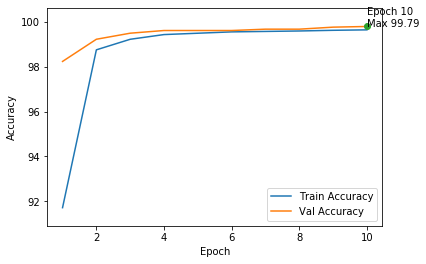

In [7]:
import torch.optim as optim
from neural_wrappers.utilities import getGenerators
from neural_wrappers.callbacks import SaveModels, PlotMetrics
from neural_wrappers.metrics import Accuracy

trainGenerator, trainSteps, valGenerator, valSteps = getGenerators(reader, miniBatchSize=20, keys=["train", "validation"])

model = Model(numFeatures=5, outClasses=3)
model.setCriterion(lossFn)
model.setOptimizer(optim.SGD, lr=0.01, momentum=0.5)
model.addCallbacks([SaveModels("best"), PlotMetrics(["Loss", "Accuracy"], ["min", "max"])])
model.addMetrics({"Accuracy" : Accuracy()})

# Train for 10 epochs using the defined data generators.
model.train_generator(trainGenerator, trainSteps, 10, valGenerator, valSteps, printMessage="v1")

##### 5. Loading the stored model and testing
By default models using the `SaveModels()` callback are stored under the name `model_best_<metric>.pkl`, in this case `model_best_Loss.pkl`. We'll load it using a new instance of the model and compute the loss on the test set. To load a model, we can use `loadWeights` or `loadModel`. The later one also loads the history of the model as well as optimizer hyperparameters and other info. It can be useful to continue a training loop that was stopped too soon by calling again `train_generator` with the loaded model.

In [8]:
model = Model(numFeatures=5, outClasses=3)
model.setCriterion(lossFn)
model.addMetrics({"Accuracy" : Accuracy()})
model.loadWeights("model_best_Loss.pkl")

testGenerator, testNumSteps = reader.iterate_once("test", miniBatchSize=20), reader.getNumIterations("test", miniBatchSize=20)
metrics = model.test_generator(testGenerator, testNumSteps)
print(metrics)

Loading model from model_best_Loss.pkl
Succesfully loaded weights (18 parameters) 
Finished loading model
{'Loss': 0.04066092933354146, 'Accuracy': 99.899980020004}
